In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

In [133]:
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
LOOKBACK = 5            # Cửa sổ quan sát quá khứ (5 ngày)
BATCH_SIZE = 16         # Batch nhỏ để cập nhật trọng số chi tiết
EPOCHS = 300            # Train sâu
PATIENCE = 25           # Kiên nhẫn đợi hội tụ
TRAIN_RATIO = 0.8
RANDOM_SEED = 42
SMOOTH_WINDOW = 3       # Cửa sổ làm mượt kết quả (3 ngày)
L2_FACTOR = 1e-5        # Hệ số phạt L2 (giúp đường dự báo mượt, không bị gai)

# Thiết lập Seed để tái lập kết quả
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [134]:
# CHUẨN BỊ DỮ LIỆU
df = pd.read_csv(FILE_PATH)

# Xử lý ngày tháng
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df['dayofyear'] = df['Date'].dt.dayofyear
else:
    df['dayofyear'] = np.arange(len(df)) % 365

# Tạo đặc trưng chu kỳ (Seasonality)
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)

pair_features = {
    "Annulus pressure": ["Annulus pressure min", "Annulus pressure max"],
    "Buffer pressure": ["Buffer pressure min", "Buffer pressure max"],
    "T": ["T min", "T max"],
    "Flow pressure": ["Flow pressure min", "Flow pressure max"]
}
for new_col, cols in pair_features.items():
    col_min, col_max = cols
    if col_min in df.columns and col_max in df.columns:
        df[f"{new_col}_avg"] = (pd.to_numeric(df[col_min], errors='coerce') + pd.to_numeric(df[col_max], errors='coerce')) / 2

measured = [
    "Gas injection rate",
    "Annulus pressure_avg",
    "Buffer pressure_avg",
    "T_avg",
    "Flow pressure_avg",
    "Choke",
]

features = measured + ['sin_doy', 'cos_doy']
TARGET = "Qliq"
WATERCUT_COL = "Water cut"

# Chia Train/Test
n = len(df)
split_idx = int(n * TRAIN_RATIO)
df_train = df.iloc[:split_idx].reset_index(drop=True)
df_test = df.iloc[split_idx:].reset_index(drop=True)

In [135]:
# SCALING & IMPUTATION
# Điền dữ liệu khuyết (Median)
imp = SimpleImputer(strategy='median')
imp.fit(df_train[features])
X_train_imp = imp.transform(df_train[features])
X_test_imp = imp.transform(df_test[features])

# Chuẩn hóa Features (X)
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train_imp)
X_test_scaled = scaler_x.transform(X_test_imp)

# Chuẩn hóa Target (y) - CỰC KỲ QUAN TRỌNG CHO ANN
scaler_y = StandardScaler()
y_train_raw = df_train[TARGET].values.reshape(-1, 1)
scaler_y.fit(y_train_raw)

StandardScaler()

In [136]:
# SEQUENCE GENERATION
def build_sequences(data, target, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(data)):
        Xs.append(data[i-lookback:i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = build_sequences(X_train_scaled, df_train[TARGET].values, LOOKBACK)
X_test_seq, y_test_seq = build_sequences(X_test_scaled, df_test[TARGET].values, LOOKBACK)

# Flatten Input: Biến đổi từ 3D (Batch, Lookback, Feat) -> 2D (Batch, Lookback*Feat)
n_train, n_steps, n_feats = X_train_seq.shape
X_train_flat = X_train_seq.reshape(n_train, n_steps * n_feats)

n_test, _, _ = X_test_seq.shape
X_test_flat = X_test_seq.reshape(n_test, n_steps * n_feats)

# Scale y train để đưa vào model
y_train_seq_scaled = scaler_y.transform(y_train_seq.reshape(-1, 1)).flatten()


In [141]:
# XÂY DỰNG COMPLEX ANN MODEL
tf.keras.backend.clear_session()

def build_complex_ann(input_dim):
    model = models.Sequential(name="Complex_ANN_Optimized")
    model.add(layers.Input(shape=(input_dim,)))

    # Layer 1: Học đặc trưng tổng quát (Large)
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)))
    model.add(layers.Dropout(0.2)) # Tắt 20% neuron ngẫu nhiên để tránh học vẹt

    # Layer 2: Học đặc trưng chi tiết (Medium)
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)))
    model.add(layers.Dropout(0.2))

    # Layer 3: Tinh chỉnh (Small)
    model.add(layers.Dense(32, activation='relu'))

    # Output Layer: Linear (Hồi quy)
    model.add(layers.Dense(1, activation='linear'))

    # Dùng Adam với learning rate nhỏ để hội tụ ổn định
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

model = build_complex_ann(X_train_flat.shape[1])
model.summary()

# TRAINING
es = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(
    X_train_flat, y_train_seq_scaled,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    verbose=2
)

Model: "Complex_ANN_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
76/76 - 5s - 61ms/step - loss: 0.7097 - mae: 0.5884 - val_loss: 0.2439 - val_mae: 0.3567 - learning_rate: 5.0000e-04
Epoch 2/300
76/76 - 0s - 3ms/step - loss: 0.5278 - mae: 0.4944 - val_loss: 0.1904 - val_mae: 0.3182 - learning_rate: 5.0000e-04
Epoch 3/300
76/76 - 0s - 3ms/step - loss: 0.4861 - mae: 0.4622 - val_loss: 0.2282 - val_mae: 0.3434 - learning_rate: 5.0000e-04
Epoch 4/300
76/76 - 0s - 3ms/step - loss: 0.4542 - mae: 0.4325 - val_loss: 0.2247 - val_mae: 0.3373 - learning_rate: 5.0000e-04
Epoch 5/300
76/76 - 0s - 3ms/step - loss: 0.4459 - mae: 0.4234 - val_loss: 0.2042 - val_mae: 0.3449 - learning_rate: 5.0000e-04
Epoch 6/300
76/76 - 0s - 3ms/step - loss: 0.4191 - mae: 0.4123 - val_loss: 0.1870 - val_mae: 0.3177 - learning_rate: 5.0000e-04
Epoch 7/300
76/76 - 0s - 3ms/step - loss: 0.4048 - mae: 0.4077 - val_loss: 0.2393 - val_mae: 0.3923 - learning_rate: 5.0000e-04
Epoch 8/300
76/76 - 0s - 3ms/step - loss: 0.4041 - mae: 0.3977 - val_loss: 0.3921 - val_mae: 0.5424 - l

In [142]:
#PREDICTION & SMOOTHING
# Dự báo (Scaled)
pred_scaled = model.predict(X_test_flat)

# Inverse Transform (Về đơn vị m3/ngày)
pred_raw = scaler_y.inverse_transform(pred_scaled).flatten()
pred_raw = np.maximum(pred_raw, 0) # Chặn dưới 0

# === SMOOTHING (Làm mượt kết quả) ===
pred_smooth = pd.Series(pred_raw).rolling(window=SMOOTH_WINDOW, center=True, min_periods=1).mean().values

y_true_test = y_test_seq

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [143]:
# ĐÁNH GIÁ (METRICS)
r2_liq_raw = r2_score(y_true_test, pred_raw)
r2_liq_smooth = r2_score(y_true_test, pred_smooth)
rmse_liq = np.sqrt(mean_squared_error(y_true_test, pred_smooth))

print("\n" + "="*40)
print(" KẾT QUẢ DỰ BÁO TỔNG LƯU LƯỢNG LỎNG (Qliq)")
print("="*40)
print(f"R2 (Raw Output):      {r2_liq_raw:.4f}")
print(f"R2 (Smoothed - Final):{r2_liq_smooth:.4f}")
print(f"RMSE:                 {rmse_liq:.4f}")

# --- TÍNH TOÁN QOIL (QUAN TRỌNG NHẤT) ---
if WATERCUT_COL in df.columns:
    # Lấy Water Cut tương ứng với tập Test (bỏ phần Lookback đầu)
    wc_vals = df_test[WATERCUT_COL].values[LOOKBACK:]

    # Xử lý đơn vị % (nếu có)
    if np.nanmax(wc_vals) > 1.5: wc_vals = wc_vals / 100.0

    # Cắt ngắn các mảng cho bằng nhau
    min_len = min(len(wc_vals), len(pred_smooth))
    wc_vals = wc_vals[:min_len]
    q_liq_final = pred_smooth[:min_len]

    # Công thức vật lý: Qoil = Qliq * (1 - WaterCut)
    q_oil_pred = q_liq_final * (1 - wc_vals)

    if 'Qoil' in df_test.columns:
        q_oil_true = df_test['Qoil'].values[LOOKBACK:][:min_len]

        r2_oil = r2_score(q_oil_true, q_oil_pred)
        rmse_oil = np.sqrt(mean_squared_error(q_oil_true, q_oil_pred))
        mae_oil = mean_absolute_error(q_oil_true, q_oil_pred)

        print("\n" + "="*40)
        print(" KẾT QUẢ SUY LUẬN DẦU (Qoil - Derived)")
        print("="*40)
        print(f"R2 Score: {r2_oil:.4f}")
        print(f"RMSE:     {rmse_oil:.4f}")
        print(f"MAE:      {mae_oil:.4f}")


 KẾT QUẢ DỰ BÁO TỔNG LƯU LƯỢNG LỎNG (Qliq)
R2 (Raw Output):      0.4663
R2 (Smoothed - Final):0.4882
RMSE:                 9.3994

 KẾT QUẢ SUY LUẬN DẦU (Qoil - Derived)
R2 Score: 0.8241
RMSE:     2.6346
MAE:      1.9350


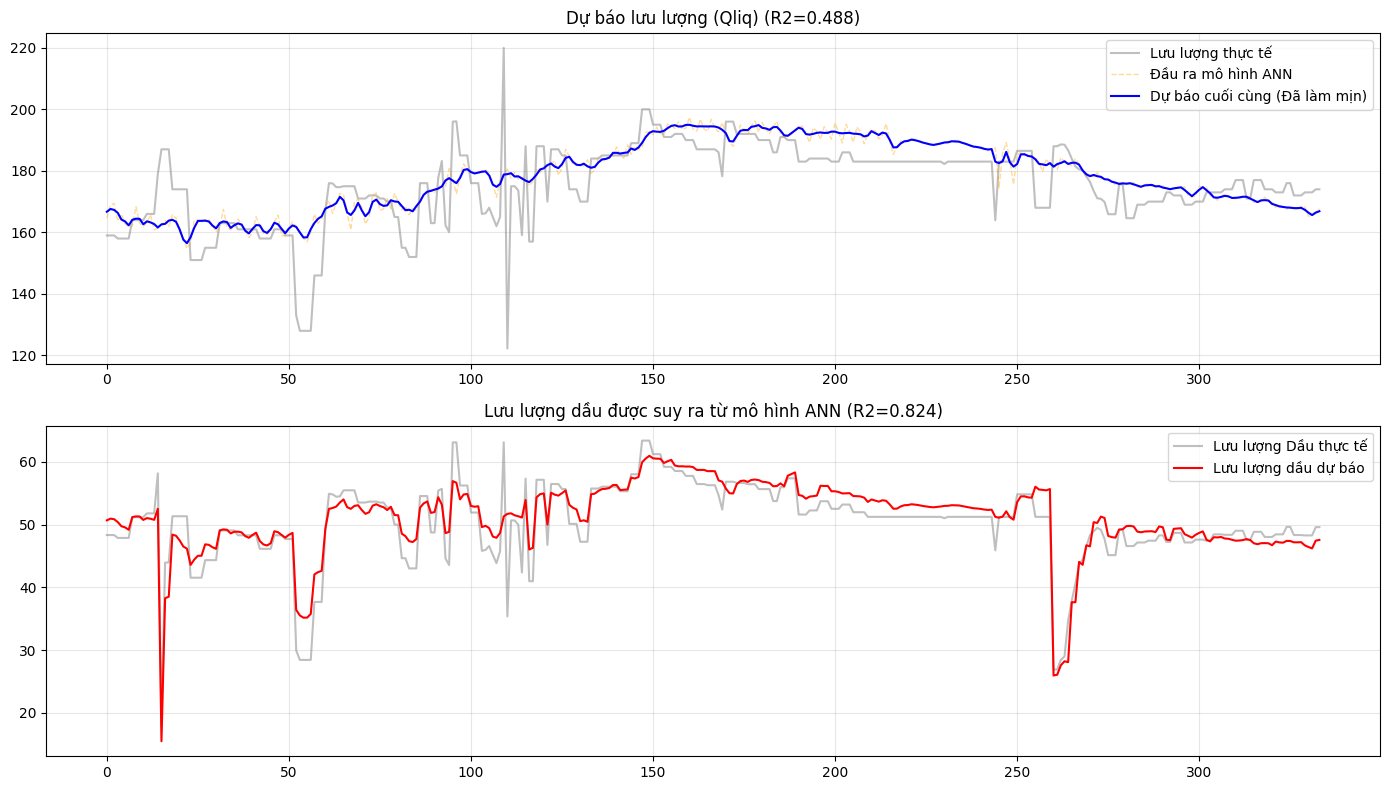

In [144]:
# VẼ BIỂU ĐỒ
plt.figure(figsize=(14, 8))

# Biểu đồ 1: Qliq (Tổng lỏng)
plt.subplot(2, 1, 1)
plt.plot(y_true_test, label='Lưu lượng thực tế', color='gray', alpha=0.5)
plt.plot(pred_raw, label='Đầu ra mô hình ANN', color='orange', alpha=0.4, linestyle='--', linewidth=1)
plt.plot(pred_smooth, label='Dự báo cuối cùng (Đã làm mịn)', color='blue', linewidth=1.5)
plt.title(f"Dự báo lưu lượng (Qliq) (R2={r2_liq_smooth:.3f})")
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ 2: Qoil (Dầu - Derived)
if 'q_oil_true' in locals():
    plt.subplot(2, 1, 2)
    plt.plot(q_oil_true, label='Lưu lượng Dầu thực tế', color='gray', alpha=0.5)
    plt.plot(q_oil_pred, label='Lưu lượng dầu dự báo', color='red', linewidth=1.5)
    plt.title(f"Lưu lượng dầu được suy ra từ mô hình ANN (R2={r2_oil:.3f})")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os

# Tạo thư mục lưu trữ (nếu chưa có)
save_dir = '/content/drive/MyDrive/Model ML'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Lưu mô hình Keras (Kiến trúc + Trọng số)
# Định dạng .keras là chuẩn mới nhất của TensorFlow, nhẹ và an toàn hơn .h5
model_path = os.path.join(save_dir, 'MTD_1X_ANN_Qliq_model.keras')
model.save(model_path)
print(f"   [+] Đã lưu Model tại: {model_path}")

# Lưu các bộ tiền xử lý (Preprocessors) bằng Joblib
# Gom tất cả vào 1 file dictionary để dễ quản lý
pipeline_artifacts = {
    'imputer': imp,          # Bộ điền dữ liệu khuyết
    'scaler_x': scaler_x,    # Bộ chuẩn hóa đầu vào
    'scaler_y': scaler_y,    # Bộ chuẩn hóa đầu ra (quan trọng để inverse)
    'features': features,    # Danh sách tên cột đầu vào (để kiểm tra khớp cột)
    'lookback': LOOKBACK     # Tham số cửa sổ quá khứ
}

pipeline_path = os.path.join(save_dir, 'MTD_1X_preprocessors.pkl')
joblib.dump(pipeline_artifacts, pipeline_path)
print(f"   [+] Đã lưu Preprocessors tại: {pipeline_path}")
print("\n>>> HOÀN TẤT! Mô hình đã sẵn sàng để triển khai.")

   [+] Đã lưu Model tại: /content/drive/MyDrive/Model ML/MTD_1X_ANN_Qliq_model.keras
   [+] Đã lưu Preprocessors tại: /content/drive/MyDrive/Model ML/MTD_1X_preprocessors.pkl

>>> HOÀN TẤT! Mô hình đã sẵn sàng để triển khai.
